## Bert-based 
First approach for this challenge is using the time-tested Bert model. Model is trained using a masking process (MLM) and also next sentence prediction (NSP) using the context aware embedding corresponding to \[CLS\] token. 

**approach**: train a set of weights for a predictive head yeilding the probabilities of each token being the start or end of the span in the context where the answer is found $\implies$ *extractive*
<div>
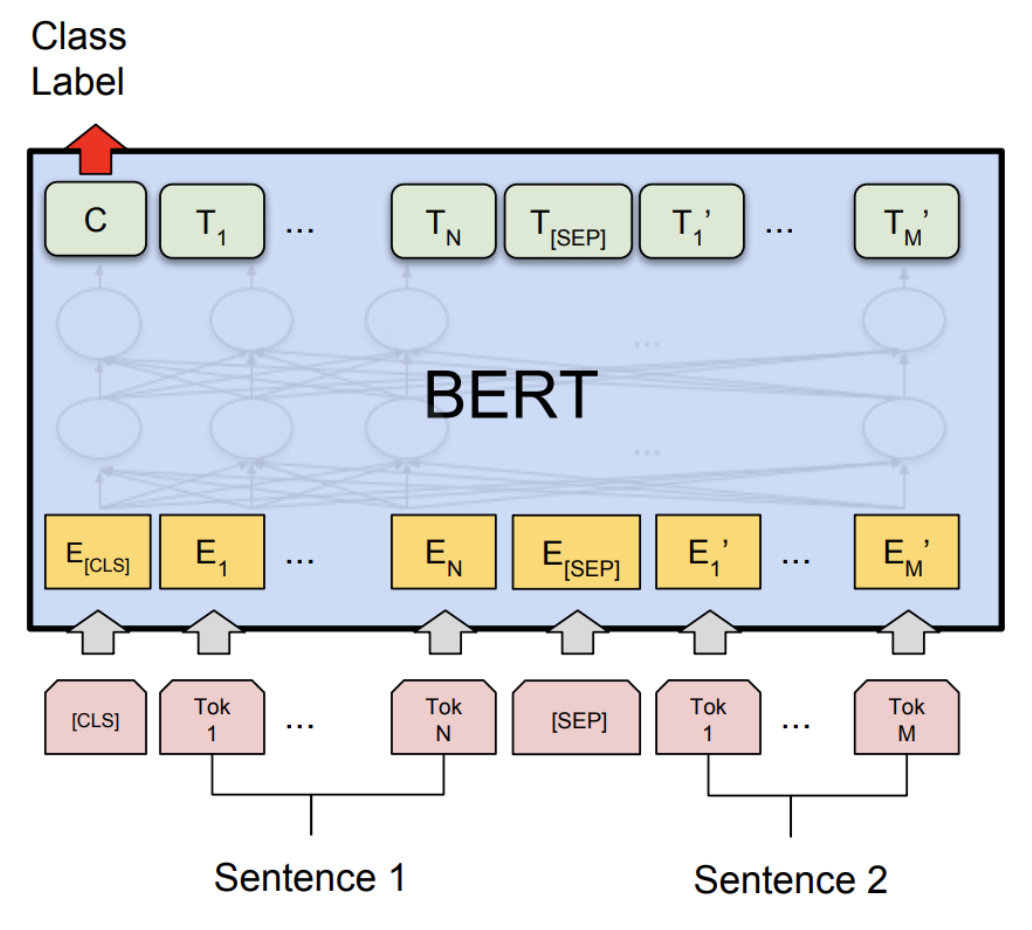
</div>

Instead of fine-tuning the model I'm gonna use a [distillbert-based one from hugging face](https://huggingface.co/twmkn9/distilbert-base-uncased-squad2)

In [1]:
# accelerate if you wanna make use of cuda-enabled devices 
#!pip install accelerate datasets transformers

In [2]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("twmkn9/distilbert-base-uncased-squad2")

# load external 
model = AutoModelForQuestionAnswering.from_pretrained("twmkn9/distilbert-base-uncased-squad2")
model 

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

Fairly certain the validation split from hugging face hosted data corresponds to the dev set from official project repo

In [3]:
from datasets import load_dataset
squad = load_dataset('squad_v2', split = 'validation')
squad[0]

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset squad_v2 downloaded and prepared to /root/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d. Subsequent calls will reuse this data.


{'id': '56ddde6b9a695914005b9628',
 'title': 'Normans',
 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'question': 'In what country is Normandy located?',
 'answers': {'text': ['France', 'France', 'France', 'France'],
  'answer_start': [159, 159, 159, 159]}}

In [4]:
#tokenize this so we can do some predictions 
tokenized = tokenizer(squad['question'], 
                      squad['context'], 
                      truncation="only_second", 
                      return_offsets_mapping=True, 
                      padding="max_length")

to make predictions with the model trained we can either use a threshold-based approach using the scores from a null response and the best candidate match inside our context.  In a really simple implementation let's just take the max score between "not answerable" and "answer found at these positions"

In [59]:
from transformers import pipeline
import torch 
from torch.nn import functional as F
device = "cuda" if torch.cuda.is_available else "cpu"
model.to(device)

def predict(idx, model=model, threshold = 0.2):
    '''
    - takes model and index of reference test set to make a prediction 
    - here our test sets are global 
    '''
    input_ids = torch.tensor(tokenized[idx].ids, device = device)
    example_id = squad[idx]['id']
    
    with torch.no_grad():
        out = model(input_ids)
    
    start = out.start_logits[0,1:].argmax()
    end = out.end_logits[0,1:].argmax()

    #check score of the candidate sol and unanswerable flag looking for a threshold 
    null_score = F.softmax(out.start_logits, dim = -1)[0,0] + F.softmax(out.end_logits, dim = -1)[0,0]
    score = F.softmax(out.start_logits, dim = -1)[0,start] + F.softmax(out.end_logits, dim = -1)[0,end]

    if (null_score-score)>threshold:
        pred = ""
    else:
        pred = tokenizer.decode(input_ids[start:end+1])
    
    
    return (example_id, pred)


In [66]:
# run with GPU
from tqdm import tqdm

preds = {}
for i in tqdm(range(len(squad))):
    k, p = predict(i, model, threshold=0.0)
    preds[k] = p


100%|██████████| 11873/11873 [03:19<00:00, 59.61it/s]


We can store predictions as (id, pred) tuples in a json file which can be cross-referenced and assessed by external script 

In [64]:
import json 
!rm pred.json
with open("pred.json", "w") as f:
    json.dump(preds, f)

In [62]:
!wget https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/ -O evaluation.py

--2023-05-20 16:51:22--  https://worksheets.codalab.org/rest/bundles/0x6b567e1cf2e041ec80d7098f031c5c9e/contents/blob/
Resolving worksheets.codalab.org (worksheets.codalab.org)... 13.68.212.115
Connecting to worksheets.codalab.org (worksheets.codalab.org)|13.68.212.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/x-python]
Saving to: ‘evaluation.py’

evaluation.py           [ <=>                ]  10.30K  --.-KB/s    in 0s      

2023-05-20 16:51:23 (204 MB/s) - ‘evaluation.py’ saved [10547]



In [22]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O dev-v2.0.json

--2023-05-20 15:51:43--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  --.-KB/s    in 0.07s   

2023-05-20 15:51:43 (58.3 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [65]:
!python3 evaluation.py ./dev-v2.0.json pred.json 

{
  "exact": 43.18200960161712,
  "f1": 55.05359099054947,
  "total": 11873,
  "HasAns_exact": 1.7881241565452093,
  "HasAns_f1": 25.56533161787954,
  "HasAns_total": 5928,
  "NoAns_exact": 84.45752733389403,
  "NoAns_f1": 84.45752733389403,
  "NoAns_total": 5945
}


In [21]:
# peace of mind 
with open("./train-v2.0.json") as f:
    lines = f.read()

lines[0:1000]

'{"version": "v2.0", "data": [{"title": "Beyonc\\u00e9", "paragraphs": [{"qas": [{"question": "When did Beyonce start becoming popular?", "id": "56be85543aeaaa14008c9063", "answers": [{"text": "in the late 1990s", "answer_start": 269}], "is_impossible": false}, {"question": "What areas did Beyonce compete in when she was growing up?", "id": "56be85543aeaaa14008c9065", "answers": [{"text": "singing and dancing", "answer_start": 207}], "is_impossible": false}, {"question": "When did Beyonce leave Destiny\'s Child and become a solo singer?", "id": "56be85543aeaaa14008c9066", "answers": [{"text": "2003", "answer_start": 526}], "is_impossible": false}, {"question": "In what city and state did Beyonce  grow up? ", "id": "56bf6b0f3aeaaa14008c9601", "answers": [{"text": "Houston, Texas", "answer_start": 166}], "is_impossible": false}, {"question": "In which decade did Beyonce become famous?", "id": "56bf6b0f3aeaaa14008c9602", "answers": [{"text": "late 1990s", "answer_start": 276}], "is_imposs